# Tension & Suspicion

In astrophysics and cosmology, we often bump against the limits of our understanding in the form of statistical _tensions_,  disagreements in the our results from two different data sources. There's two practical reasons we might care about tensions:
1. When asking if two measurements properly agree with one another
2. When considering if two data-sets are similar enough to pool them together

In the simplest of cases, like hubble tension diagram shown below, we can can use the rough yardstick of a **sigma tension**, $T$. Assuming our measurement uncertainties are gaussian, sigma-tension asks: <span style="font-family: verdana"><i>"how many standard deviations are result $A$ and result $B$ separated by"?</i></span>. The famous frequentist approach to this simple 1D case is to assign a P value based on how likely the separation is to be a product of coincidence:

$$
P = p(t > T) = \int_T^\infty \mathcal{N}(t) dt
$$

This a workable approach when our are simple one dimensional gaussians, but what about complicated, high dimensional multivariate models? For a generalizeable and principled approach to the question of tensoin, we need to turn to the test-stastics of Bayesian modelling. In this post, I introduce the reader to _bayesian suspiciousness_, a little known item in the bayesian tool-belt that is well suited to the vague priors endemic to cosmology.


<p style="text-align: center;"> 
<figure>
    <img src="./media/hubbletension.png" width="400">
</figure>

<p style="text-align: center; font-family: arial;width: 600px; margin:0 auto;" ><b>Diagram showing how tension in measurements of the hubble parameter <a href="https://arxiv.org/pdf/2105.05208.pdf">Perivolaropoulos & Skara 2022</a></b></p></p>

In part one of this post, I introduce the unfamiliar reader to two of the more common tools of bayesian "goodness of fit": _evidence_ and _information_ (also sometimes called entropy or the [Kullback Leiber divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)", and demonstrate the shortfalls these have in measuring statistical tension. I then introduce bayesian suspiciousness, and show how it dodges the pitfalls of its better known cousins. In part 2, I derive all three tools for a simple 1D gaussian case to help offer an intuitive "feel" for what they represent. I extend this to the general multivariate case, and offer an interpretation of suspiciousness in P-value terms as an olive branch to the frequentists of the world.

**Index**
- [Part 1: A Gentle Introduction to Suspiciousness by way of Example](#part1)
- [Part 2: Translating to Frequentism - Interpreting Suspiciousness with P Values](#part2)

In [1]:
import numpy as np
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
from matplotlib.patches import Ellipse

---
## Part 1: A Gentle Introduction to Suspiciousness by way of Example  <a id='part1'></a>

When we've got a nice gaussian distribution in one parameter, tension is conceptually pretty intuitive and easy to judge by eye. Things get a little messier once we extend to multiple dimensions, and in this section we'll use a simple linear regression example to show how quickly "eyeballing it" can fail us, and then venture into the more generalizeable Bayesian domain, eventually settling suspiciousness as the best tool for quantifying tension between two datasets.

Tension is usually framed in terms of the question:

<p style="text-align: center; font-family: verdana"><i>"Do these two measurements agree with one another?"</i></p>

But we can wring a lot more out of this by pivoting to the subtly different question: 

<p style="text-align: center; font-family: verdana"><i>"Do these two datasets measure the <u>same</u> variable?"?</i></p>

This may not seem like much of a change, but we're now asking a rigorously defined question. We have one model where the datasets share the same set of parameters, and another where they each have their own independent set. 

Consider the simple example of a linear regression shown below.  Do data sets $A$ and $B$ actually follow the same trend? At first glance, we can give a confident "kinda", but there might still be a tension too subtle to see by eye.

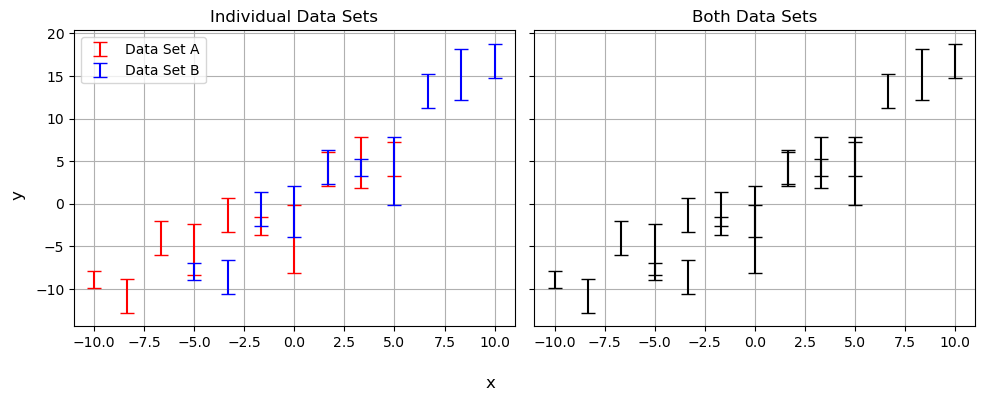

In [2]:
def gen_data(Ndata = 10, seed = 12, true_params = {'m':1,'c':0}, escatter=1, ebar = 1, Xrange= {-10,10}):
    np.random.seed(seed)
    m, c = true_params['m'], true_params['c']
    X = np.linspace(Xrange[0], Xrange[1], Ndata) 
    E = (np.random.poisson(lam=escatter, size=len(X))+1) / escatter * ebar + 0.01
    Y = m * X + c + E*np.random.normal(size=len(X)) # Linear rel /w random noise based on 'E'  
  
    return(X, Y, E) 

XA, YA, EA = gen_data(true_params = {'m':1,'c':0}, Xrange = [-10,5])
XB, YB, EB = gen_data(true_params = {'m':1.7,'c':-0.5}, Xrange = [-5,10])
XAB, YAB, EAB = np.concatenate([XA,XB]), np.concatenate([YA,YB]), np.concatenate([EA,EB])

fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,4))
ax[0].errorbar(XA,YA,EA, fmt = 'none', c='r', capsize=5, label = "Data Set A")
ax[0].errorbar(XB,YB,EB, fmt = 'none', c='b', capsize=5, label = "Data Set B")
ax[1].errorbar(XAB,YAB,EAB, fmt = 'none', c='k', capsize=5, label = "Both Data Sets")
ax[0].grid()
ax[1].grid()

ax[0].set_title("Individual Data Sets")
ax[1].set_title("Both Data Sets")

ax[0].legend()


fig.supxlabel('x')
fig.supylabel('y')
fig.tight_layout()
plt.show()

The power of Bayesian analysis lets us dig a little deeper by plotting the probability contours for $m$ and $c$ for each model, shown below. It's pretty easy to see that the results are in tension, barely overlapping at all, but naive measurements like sigma-tension fail at the first hurdle even in his well behaves example. The discrepency along the $m$ axis is obvious, but imagine this were some larger more complicated model where we only measured $c$ and marginalized over $m$ as a nuisance parameter: the tension would go completely unnoticed. We could imagine some trick of measuring sigma-tension along principle axis' or some such, but how would this scale into high dimensions or weird non-gaussian contours? We need a _general_ test of tension that we can apply to any system of arbitrary complexity.

In [3]:
# Chain processing Code
def get_KL(chain, poten, prior):
    Z = get_Z(chain, poten, prior)
    M, C = chain['m'], chain['c']
    m_mu, m_sig = prior['m']
    c_mu, c_sig = prior['c']
    log_like = -poten - np.log(Z)
    priorfunc = np.exp(-1/2 * (((M-m_mu)/m_sig)**2 + ((C-c_mu)/c_sig)**2)) / (2*np.pi) / c_sig / m_sig

    out = (np.log(priorfunc) - log_like).mean()
    return(-out)

def get_Z(chain, poten, prior):
    M, C = chain['m'], chain['c']
    
    COV = np.cov(np.stack([M,C]))
    sig1, sig2 = np.sqrt(np.linalg.eig(COV).eigenvalues)
    
    out = np.exp(-poten).max() * (sig1*sig2 * 2*np.pi)
    return(out)

In [4]:
# NumPyro Model & Default Priors

default_priors = {'m': [0.0,10],
                 'c': [0.0,20] }

def model(x,y,e, priors = default_priors):
    m_mu, m_sig = priors['m']
    c_mu, c_sig = priors['c']
    m = numpyro.sample('m', numpyro.distributions.Normal(m_mu,m_sig))
    c = numpyro.sample('c', numpyro.distributions.Normal(c_mu,c_sig))
    y_pred = m*x+c
    with numpyro.plate('data',len(x)):
        numpyro.sample('y', numpyro.distributions.Normal(y,e), obs=y_pred)

In [5]:
# Calculation for prior range 1
sampler = numpyro.infer.MCMC(numpyro.infer.NUTS(model),
                             num_samples = 100000,
                             num_warmup = 500,
                             num_chains = 1,
                             progress_bar = False)

print("Doing Set A")
sampler.run(jax.random.PRNGKey(1), XA,YA,EA, extra_fields = ("potential_energy",))
res_A = sampler.get_samples()
poten_A = sampler.get_extra_fields()['potential_energy']
D_A = get_KL(res_A, poten_A, default_priors)
Z_A = get_Z(res_A, poten_A, default_priors)

print("Doing Set B")
sampler.run(jax.random.PRNGKey(1), XB,YB,EB, extra_fields = ("potential_energy",))
res_B = sampler.get_samples()
poten_B = sampler.get_extra_fields()['potential_energy']
D_B = get_KL(res_B, poten_B, default_priors)
Z_B = get_Z(res_B, poten_B, default_priors)

print("Doing Both Sets")
sampler.run(jax.random.PRNGKey(1), XAB,YAB,EAB, extra_fields = ("potential_energy",))
res_AB = sampler.get_samples()
poten_AB = sampler.get_extra_fields()['potential_energy']
D_AB = get_KL(res_AB, poten_AB, default_priors)
Z_AB = get_Z(res_AB, poten_AB, default_priors)
print("Done")

rel_inf = D_A+D_B - D_AB

Zrat = Z_A*Z_B / Z_AB

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Doing Set A
Doing Set B
Doing Both Sets
Done


In [6]:
# Calculation for prior range 2
expanded_priors = {'m':[0.0,100.0],
                      'c': [0.0,200.0] 
}

print("Doing Set A")
sampler.run(jax.random.PRNGKey(1), XA,YA,EA, extra_fields = ("potential_energy",), priors=expanded_priors)
res_A2 = sampler.get_samples()
poten_A2 = sampler.get_extra_fields()['potential_energy']
D_A2 = get_KL(res_A2, poten_A2, expanded_priors)
Z_A2 = get_Z(res_A2, poten_A2, expanded_priors)

print("Doing Set B")
sampler.run(jax.random.PRNGKey(1), XB,YB,EB, extra_fields = ("potential_energy",), priors=expanded_priors)
res_B2 = sampler.get_samples()
poten_B2 = sampler.get_extra_fields()['potential_energy']
D_B2 = get_KL(res_B2, poten_B2, expanded_priors)
Z_B2 = get_Z(res_B2, poten_B2, expanded_priors)

print("Doing Both Sets")
sampler.run(jax.random.PRNGKey(1), XAB,YAB,EAB, extra_fields = ("potential_energy",), priors=expanded_priors)
res_AB2 = sampler.get_samples()
poten_AB2 = sampler.get_extra_fields()['potential_energy']
D_AB2 = get_KL(res_AB2, poten_AB2, expanded_priors)
Z_AB2 = get_Z(res_AB2, poten_AB2, expanded_priors)

print("Done")

rel_inf2 = D_A2+D_B2 - D_AB2

Zrat2 = Z_A2*Z_B2 / Z_AB2

Doing Set A
Doing Set B
Doing Both Sets
Done


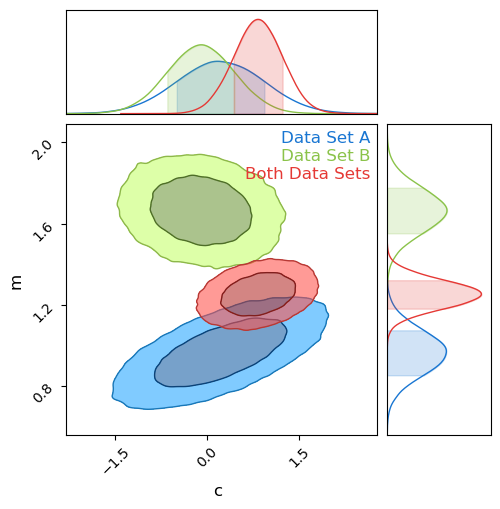

Evidence Ratio: 7.0440e+01
Relative Information Gain: 6.3187


In [7]:
# Corner plot for prior 1
C = ChainConsumer()
C.add_chain(res_A, name = "Data Set A")
C.add_chain(res_B, name = "Data Set B")
C.add_chain(res_AB, name = "Both Data Sets")
C.plotter.plot(figsize=(5,5))
plt.show()

print("Evidence Ratio: %.4e" %Zrat)
print("Relative Information Gain: %.4f" %(rel_inf))

When asking if they agree, we're really comparing two models, one with a single gradient and offset, and another with one for each source:

<b><u>Model 1 - Indepdenent</u></b>
<p style="text-align: center; font-family: verdana"><i>"$A$ and $B$ have different offsets and gradients"</i></p>
$$
P(m_A,m_B,c_A,c_B|Y_A,Y_B)=P(m_A,c_A \vert Y_A)\cdot P(m_B,c_B \vert Y_B)
$$

<b><u>Model 2 - Simultaneous</u></b>
<p style="text-align: center; font-family: verdana"><i>"$A$ and $B$ <u>share</u> the same offsets and gradients"</i></p>
$$
P(m,c|Y_A,Y_B)=P(m,c \vert Y_A)\cdot P(m,c \vert Y_B)
$$

Posing the question in this form, we can leverage the vast toolbox of bayesian model comparison. 


### Bayesian Evidence 

Whenever we define a bayesian model for some parameters $\theta$, the model consistents of two components:
1. A generative model of what observations a given $\theta$ would produce, and
2. A _prior_ on high likely any given $\theta$ is before measurement
It's important to remember that the the total probablistic model is both of these together. 

The core idea of Bayes theorem is that the probabilty (or goodness of fit) for parameters $\theta$ is proporional to how likely they are is to exist _and_ how well it reproduces our data:

$$
p(\theta \vert y) \propto P(y \vert \theta) \cdot \pi(\theta)
$$

The RHS is unnormalized, and so we scale $p(\theta \vert y)$ back to a probability density with a proportionality constant $Z$. We often handwave the constant away, as we often only care about the _relative_ performance of any two points in parameter space. However, this constant has physical meaning: It's the _total_ "likelihood mass" of the entire posterior distribution:

$$
Z = \int \mathcal{L}(\theta \vert y)\cdot \pi(\theta) d\theta
$$

This is the **Bayesian Evidence**, and describes the overall ability of the model to explain / reproduce the data. Because the evidence is a measure of how well a model performs overall, we can compare the performance of two models by looking at the ratio of these two. E.g, for models '1' and '2':

$$
\mathcal{R}_{12} = \frac{Z_1}{Z_2}
$$

This **Evidence Ratio** gives us a direct comparison of how well two models match our data. if $\mathcal{R} \gg 1$, it implies that model 1 is a significnatly better fit than model 2.

#### Failure of Evidence Ratio in Measuring Tension

We've already seen how tension can be described as a type of model comparison, and so it's a natural step to try and use evidence ratios to along that line or reasoning:

$$
\mathcal{R} = \frac{Z_A Z_B}{Z_{AB}}
$$

If $\mathcal{R} \gg 1$, it implies that combining the datasets gives worse results, i.e. that $A$ and $B$ are in tension. As long as we have well defined priors, this is a perfectly valid approach. Unfortunately, it can fail on contact reality, particularly in astrophysics where our priors are overly vague and not always rigorously defnied.

Suppose we have a vague prior with width '$w$'. Because $\pi(x)\propto w^{-1}$, increasing the prior width has an effect of "diluting" the model evidence:

$$
p(\theta \vert y) \propto \pi(\theta) \rightarrow Z \propto \frac{1}{w}
$$

This carries through to the evidence ratio. Because the "seperate" model has twice as many parameters, this means it gets penalized twice as much by this dilution:

$$
R = \frac{Z_A Z_B}{Z_{AB}} \propto \frac{w^{-1}\cdot w^{-1}}{w^{-1}} \propto w^{-1}
$$

Again, if our priors are meaningfully defined and well constrained, this isn't an inherent problem. However, we're often faced with cases where we only have some vague constraint on a parameter, e.g. $x>0$, with limits being a bit arbitrary. The evidence ratio is completely at the mercy of this arbitrary decision.

For example consider the linear regression from before. Because we had no a-piori information about $m$ or $c$, I used extremely vague normally distributed priors:

$$
\pi(m,c) = \pi(m) \pi(c), \;\;\; \pi(m)=\mathcal{N}(m,0,10), \;\;\; \pi(c)=\mathcal{N}(c,0,20)
$$

But this prior width of $\sigma_{\pi_m}=10$ and $\sigma_{\pi_c}=20$ weren't chosen for any reason, they were just set to be wide enough to not distort my final results. I would have been just as justified picking a prior ten times wider:

$$
\pi(m)=\mathcal{N}(m,0,100), \;\;\; \pi(c)=\mathcal{N}(c,0,200)
$$



In [8]:
# Corner Plot 2
C2 = ChainConsumer()
C2.add_chain(res_A2, name = "Data Set A")
C2.add_chain(res_B2, name = "Data Set B")
C2.add_chain(res_AB2, name = "Both Data Sets")

print("Evidence Ratio: %.4e" %Zrat2)

print("Relative Information Gain: %.4f" %(rel_inf2))

Evidence Ratio: 7.2125e-01
Relative Information Gain: 10.8864


INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUnicode


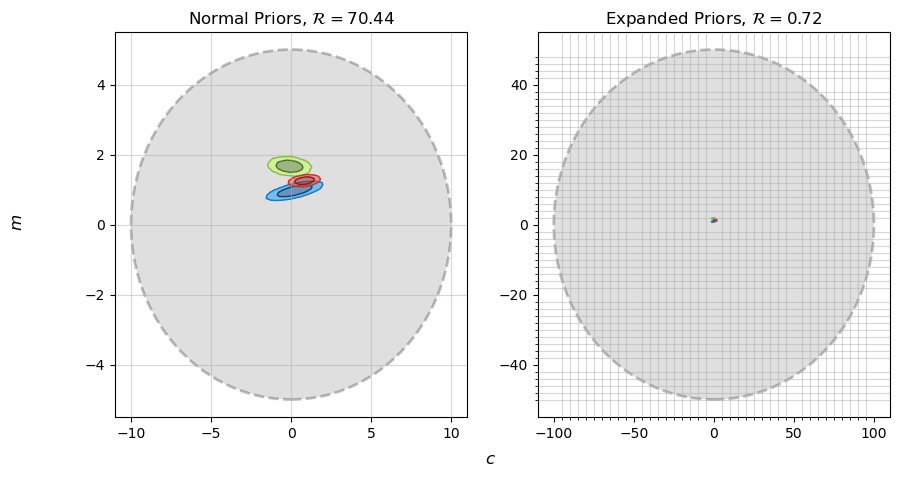

In [9]:
# Prior boundary plot 1
fig, ax = plt.subplots(1,2, figsize=(10,5))

#-------------------------------
C.plotter.plot_contour(ax[0], 'c', 'm')
ellipse = Ellipse(xy=(default_priors['c'][0], default_priors['m'][0]), width=default_priors['c'][1], height=default_priors['m'][1], 
                        edgecolor='k', ls='--', fc='grey', alpha = 0.25, lw=2, label="1 sigma prior width", zorder=-10)

ellipse = Ellipse(xy=(default_priors['c'][0], default_priors['m'][0]), width=default_priors['c'][1], height=default_priors['m'][1], 
                        edgecolor='k', ls='--', fc='grey', alpha = 0.25, lw=2, label="1 sigma prior width", zorder=-10)
ax[0].add_patch(ellipse)
ax[0].set_title("Normal Priors, $\mathcal{R} = %0.2f$" %Zrat)

#-------------------------------
C2.plotter.plot_contour(ax[1], 'c', 'm')
ellipse = Ellipse(xy=(expanded_priors['c'][0], expanded_priors['m'][0]), width=expanded_priors['c'][1], height=expanded_priors['m'][1], 
                        edgecolor='k', ls='--', fc='grey', alpha = 0.25, lw=2, label="1 sigma prior width", zorder=-10)
ax[1].add_patch(ellipse)
ax[1].set_title("Expanded Priors, $\mathcal{R} = %0.2f$" %Zrat2)

ax[0].grid( alpha=0.5, zorder=-1)

ax[1].set_xticks(np.arange(-200/2,200/2,5), minor=True,)
ax[1].set_yticks(np.arange(-100/2,100/2,2), minor=True,)
ax[1].grid(which='minor', zorder=-1, alpha=0.5)

fig.supxlabel('$c$')
fig.supylabel('$m$')
plt.show()

Using moderately vague priors, we get $\mathcal{R}\approx 70$, indicating that the data sets are in clear tension. Using _very_ vague priors, expanding them by a factor of 10, our evidence ratio gets scaled down to $\mathcal{R}\approx 0.7$, which tells us that the data sets are _not_ in clear tension. This is the central problem with evidence ratios: our result has completely changed based on an arbitrary decision.

### Information

While evidence measures how well the model describes data data, another measure of model performance is its information (also called the entropy or [Kullback-Lieber divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)) wich measures how well the model _constrains_ its parameters. 

Information is defined as the average log difference between the posterior and prior:

$$
    I_m = \int_\pi{p_m(\theta)\cdot \ln \left|\frac{p_m(\theta)}{\pi(\theta)} \right|}d\theta = E \left[ \ln \vert \mathcal{L}(\theta) \vert - \vert \pi(\theta) \vert \right]
$$

If $I_m>0$, this indicates that information has been 'gained' about $\theta$, i.e. that our data is meaningfully constraining the parameter compared to our prior. This information can be applied to cases of model selection in the case of two models that are the same but for the inclusion of some extra parameter. If the parameter is poorly constrained, i.e. the relative gain in information between the models is low, it indicates that the more complex model with the parameter included can be rejected.

#### The Problem With Information

Information might seem to be a promising lead, but it doesn't actually tells us much about how well the model performs. It only tells us how well it _constrains_ parameters. It has another shortfall: just like evidence, varies with our prior width. Information is _gained_ when our results are better constrained than the prior. A wider prior means _more_ information is gained.

$$
\exp(I) \propto w
$$

This propogates through to the _relative_ information gain:

$$
\Delta I = I_A + I_B - I_{AB}
$$

This has the opposite problem to the evidence ratio: it gets arbitrarily better as the prior becomes more vague:

$$
\exp(\Delta I) \propto w
$$

For example, comparing moving beween our moderate and vague priors from before, we get:

$$
\Delta I_\text{moderate} = 6.32, \;\;\; \Delta I_\text{vague} = 10.89
$$

The prior has increased in volume by a factor of 100, corresponding to an increase in $\Delta I$ of $\ln \vert 100 \vert\approx 4.6$.

### Suspiciousness

Individually, evidence and information fail to give us what we want: a measure of model "goodness" that is immune to changes in prior width. Our "model" consist of both a likelihood and a prior, and we want to "remove" the effect of the prior on our answers, as the prior is somewhat arbitrary. Fortunately, all is not lost. Noting that:
1. Evidence decreases with prior width
2. Information increases in the same way

We can combine evidence and information to get a new measurement, **suspiciousness**

$$
S = ln \vert Z \vert + D
$$

This new measurement is **invariant with prior width**:

$$
\Delta S = S_A + S_B - S_{AB} \propto w^0
$$

Comparing our three tools, we can see that the change in $\mathcal{R}$ gets cancled out by the change in $\Delta I$, leaving $\Delta S$ invariant to within calculation error:

<p style="text-align: center;"> 
<table>
    <tr>
        <th>Statistic</th>
        <th>Moderate <br> Priors</th>
        <th>Vague <br> Priors</th>
    </tr>
    <tr>
        <th>Log-Evidence</th>
        <td>4.254</td>
        <td>-0.327</td>
    </tr>
    <tr>
        <th>Information</th>
        <td>6.32</td>
        <td>10.89</td>
    </tr>
    <tr>
        <th>Suspiciousness</th>
        <td>10.57</td>
        <td>10.56</td>
    </tr>
</table>
</p>

----

## Part 2: Translating to Frequentism - Interpreting Suspiciousness with P Values <a id='part2'></a>
In part 1 I've covered an example application of evidence, information & suspiciousness, but only touched on the underlying maths with a loose hand-wave. In this section, I'll work out these model comparison tools by-hand for the simplest possible case of 1D gaussians to provide more intuitive feel for what they represent and how they can be interpreted in a more frequentist mindset of P-values and sigma tensions.

Suppose our two datasets $A$ and $B$ produce clean gaussian likelihoods with scaling factors / integrals $S_A$ and $S_B$:

$$
\mathcal{L}_A(x)= \frac{S_A}{\sqrt{2 \pi \sigma_A^2}} \exp{ \left( \frac{-1}{2} \left(\frac{x-\mu_A}{\sigma_A}\right)^2 \right)}, \;\;\;
\mathcal{L}_B(x)= \frac{S_B}{\sqrt{2 \pi \sigma_B^2}} \exp{ \left( \frac{-1}{2} \left(\frac{x-\mu_B}{\sigma_B}\right)^2 \right)}
$$

INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode


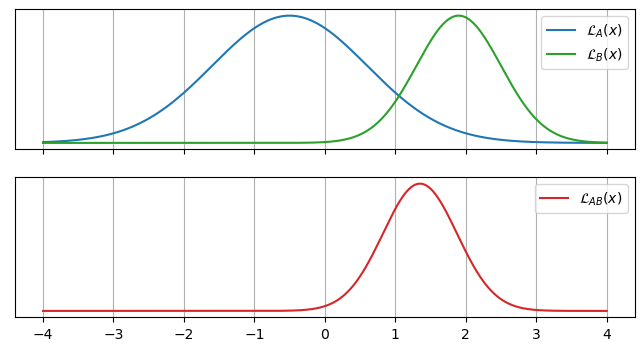

In [26]:
from scipy.stats import norm

X = np.linspace(-4,4, 1024)
mu1, mu2 = -0.5, 1.9
sig1, sig2 = 1.1, 0.6

LA, LB = norm.pdf((X-mu1)/sig1), norm.pdf((X-mu2)/sig2)
LAB = LA*LB

fig, ax = plt.subplots(2,1, figsize=(8,4), sharex=True)
ax[0].plot(X,LA, label="$\mathcal{L}_A(x)$", c='tab:blue')
ax[0].plot(X,LB, label="$\mathcal{L}_B(x)$", c='tab:green')
ax[1].plot(X,LAB, label="$\mathcal{L}_{AB}(x)$", c='tab:red')

ax[0].legend()
ax[1].legend()

ax[0].set_yticks([])
ax[1].set_yticks([])

ax[0].grid()
ax[1].grid()

plt.show()

The likelihood for the two combined data set is just the product of these, another gaussian of the form:

$$
\mathcal{L}_{AB}(x)= \frac{S_{AB}}{\sqrt{2 \pi \sigma_{AB}^2}} \exp{ \left( \frac{-1}{2} \left(\frac{x-\mu_{AB}}{\sigma_{AB}}\right)^2 \right)}
$$

With the mean '$\mu_{AB}$' and standard deviation '$\sigma_{AB}$' based on the inverse-variance weighted average of the two:

$$
\mu_{AB} = \left(\frac{\mu_A}{\sigma_A^2} + \frac{\mu_B}{\sigma_B^2}\right)\cdot \sigma_{AB}^2, \;\;\; 
\sigma_{AB} = \left(\frac{1}{\sigma_A^2} + \frac{1}{\sigma_B^2}\right)^{-\frac{1}{2}}
$$

But with a scaling factor / integral that depends on the separation of $\mathcal{L}_A(x)$ and $\mathcal{L}_B(x)$:

$$
S_{AB} = S_A S_B \sqrt{2 \pi} \frac{\sigma_{AB}}{\sigma_A \sigma_B}
$$

By itself this isn't too illuminating, but can be rearranged into a more intuitive form:

$$
S_{AB} =S_A S_B \cdot \frac{1}{\sqrt{2 \pi (\sigma_A^2 + \sigma_B^2)^2}} \exp{ \frac{-1}{2} \left(\frac{(\mu_A-\mu_B)^2}{\sigma_A^2 + \sigma_B^2} \right)}
$$

Aside from the scaling factors we inherited $A$ and $B$, this is a normal distribution based directly on the sigma tension:

$$
S_{AB} = S_A S_B \cdot \mathcal{N}(T), \;\;\;\; T = \frac{\lvert \mu_A-\mu_B \rvert }{\sqrt{\sigma_A^2 + \sigma_B^2}}
$$

The normal distribution here is the pdf that $\mu_A-\mu_B = 0$, the typical frequentist measure of whether $A$ and $B$ agree with eachother:

### Evidence Ratios

Equipped with expressions for our likelihoods, we can start looking at our bayesian model comparison tools. To keep the working simple, I'll work with a prior _uniform_ prior distribution that is much wider than any of the gaussians:

$$
\pi(x) = 
    \begin{cases}
      \frac{1}{w} & \text{if } x\in \left[ -\frac{w}{2}, \frac{w}{2} \right]\\
      0 & \text{otherwise}
    \end{cases}       
$$

As long as this prior is wide enough ($w \gg \sigma_A,\sigma_B,\sigma_{AB}$), our evidence will be "posterior dominated", making evidence integral a lot easier to calculate. In the limit $w \rightarrow \infty$, the prior just appears a scaling factor to the distributions and their integrals:

$$
Z_A = \frac{S_A}{w}, \;\;\; Z_B = \frac{S_B}{w}, \;\;\; Z_{AB} = \frac{S_{AB}}{w}
$$

Giving a similarly friendly expression for the evidence ratio, $\mathcal{R}$:

$$
\mathcal{R} = \frac{Z_{AB}}{Z_A Z_B} = \frac{S_{AB}}{S_A S_B} \cdot w
$$

Rembering before that the scaling factor was based on the sigma tension, $\frac{S_{AB}}{S_A S_B} = \mathcal{N}(T)$, this just gives:

$$
\mathcal{R} = \mathcal{N}(T) \cdot w
$$

This is what we expect: because our independent model has twice as many variables, the diluting effect of the prior is twice as strong for that model. This means that $\mathcal{R} \propto w$.

### Information

The information for a gaussian is the KL-divergence between that distribution and the prior, which is the same as being the expectation value of the log-difference bewteen the two. For the gaussian likelihood of dataset $A$, the information is:

$$
I_A = \int_x { p_A(x) \ln{ \left( \frac{p_A(x)}{\pi(x)} \right) } } dx
= E \left[ \ln{ (p_A(x)) } - \ln{ (\pi(x)) } \right]_{p_A}
$$

Thanks to our uniform prior and the way we defined $\mathcal{L}_A(x)$, the probability densite $p_A(x)$ unsuprisingly comes out to a normalizef gaussian:

$$
p_A(x) = \frac{\mathcal{L_A(x) \pi(x)}}{Z_A} = \frac{\mathcal{L_A (x)}}{S_A} = \frac{1}{\sqrt{2 \pi \sigma_A^2}} \exp{ \left( \frac{-1}{2} \left(\frac{x-\mu_A}{\sigma_A}\right)^2 \right)}
$$

Which leads us break our log terms into simpler pieces, most of which are just constants:

$$
\ln{ (p_A(x)) }= -\frac{1}{2} \ln{ (2 \pi \sigma_A) }-\frac{1}{2} \left(\frac{x-\mu_A}{\sigma_A}\right)^2, \;\;\; \ln{ (\pi(x)) } = -\ln(w)
$$

And a similarly friendly expression for $I_A$:

$$
I_A = E \left[ \ln{ (p_A(x)) } - \ln{ (\pi(x)) } \right]_{p_A}
 = 
 - E \left[\frac{1}{2} \ln{ (2 \pi \sigma_A) } \right]_{p_A}
 - E \left[\frac{1}{2} \left(\frac{x-\mu_A}{\sigma_A}\right)^2 \right]_{p_A}
 + E \left[\ln{w} \right]_{p_A}
$$

Because most of these terms are constant, this expectation value is trivial to evaluate. The only exception is the square term, but we know that $E \left[ (x-\mu_A)^2 \right] = \sigma_a^2$ by definition making this term cancel out and giving an intuitive expression.

$$
I_A = \ln \left( \frac{w}{\sigma_A} \right) - \frac{1}{2} (\ln(2\pi) +1)
$$

Information measures how well constrained $x$ is _relative to the prior_, and so increases as the prior becomes more vague. By a similar token, know the information for $B$ and the combined dataset is:

$$
I_B = \ln(w) - \ln(\sigma_B) - \frac{1}{2} (\ln(2\pi) +1), \;\;\;
I_{AB} = \ln(w) + \frac{1}{2} \ln \left(\frac{1}{\sigma_A^2} + \frac{1}{\sigma_B^2}\right) - \frac{1}{2} (\ln(2\pi) +1)
$$

Yielding a _relative_ information gain between the models:

$$
\Delta I = I_{AB} - I_A - I_B
= \frac{1}{2} (\ln(2\pi) +1) + \ln \left( \frac{\sigma_A \sigma_B}{\sigma_{AB}^2} \right) + \ln \left( \frac{\sigma_{AB}}{w} \right)
$$

Information tells us about the constraint of parameters, i.e. the relative width of our distributions, and doesn't tell us much about how well the information actually fits the data.

### Suspiciousness &  P-Value

Noting that evidence ratio scales like $\mathcal{R}\propto w$, and relative information scales like $\exp(\Delta I) \propto w^{-1}$, suspiciousness is an obvious combination of these two that cancels out the prior dependence:

$$
\Delta S = \ln ( \mathcal{R}) + \Delta I
$$

With expressions for evidence ratio and relative information, the relative suspicousness is straightforward:

$$
\Delta S = \frac{1}{2}-\frac{1}{2} \frac{(\mu_A-\mu_B)^2}{\sigma_A^2 + \sigma_B^2} 
= \frac{1}{2}-\frac{T^2}{2}
$$

Aside from a loose constant term, suspciciousness recovers an expression for the sigma tension completely independent of the prior! A natural step to interpret this as a test statistic on a normal distribution:

$$
T =\sqrt{1-2 \Delta S}
$$

And then define a P value in the typical frequentist way:

$$
P = p(t > T) = \int_T^\infty \mathcal{N}(t) dt
$$

Doing this for a 1D gaussian, we can get a feel for how $\Delta S$ lines up with different P values:

<p style="text-align: center">
<table style="text-align: center; font-family: courier; font-size: 11pt">
    <tr>
        <th> P-Value </th> <th>$\sigma$-Tension</th> <th>Suspiciousness</th>
    </tr>
    <tr>
        <th> 0.05 </th> <td>-1.645</td> <td>-0.853</td>
    </tr>
    <tr>
        <th> 0.01 </th> <td>-2.326</td> <td>-2.206</td>
    </tr>
    <tr>
        <th> 0.001 </th> <td>-3.090</td> <td>-4.275</td>
    </tr>
</table>
</p>

### Extending To Non-Guassian & Multiple Dimensions
So far we've only looked at one dimensional gaussian distributions. This may seem like an overly restrictive case, but consider:
1. Any probability distribution can be reparametrized into a similarly dimensioned gaussian of arbitrary covariance  
2. Evidence and information, and by extension suspiciousness, remain invariant under reparameterization  
3. $\ln{\lvert Z\rvert}$, $I$ and $S$ compose linearly for uncorrelated joint distributions, such as those recovered by **(1)**   

Combining **(2)** and **(3)**, we know that the relative suspiciousness of any ‘D’ dimensional gaussian distribution can be found by summing together the suspiciousness of its component distributions:

$$
\Delta S_D=\sum_{i=1}^{D}{\Delta S_i}=\sum_{i=1}^{D}{\frac{1}{2}-\frac{1}{2}\frac{\left(\mu_{A,i}-\mu_{B,i}\right)^2}{\sigma_{A,i}^2+\sigma_{B,i}^2}}
$$

Or, rearranging for suspiciousness:

$$
1-2\cdot\Delta S_D=\sum_{i=1}^{D}\frac{\left(\mu_{A,i}-\mu_{B,i}\right)^2}{\sigma_{A,i}^2+\sigma_{B,i}^2}
$$

In the one dimensional case, $\Delta S$ is the square of a normally distributed random variable. In the $D$ dimensional case, it is the _sum_ of the square of many normally distributed random variables, i.e. it obeys a $D$ degree of freedom [$\chi^2$ distribution](https://en.wikipedia.org/wiki/Chi-squared_test):

$$
1-2\cdot\Delta S_D= \sum_{i=1}^{D} (T_i^2) = \chi^2_D
$$

This means we can interpret the suspiciousness as a P value by asking "what is the chance we would see this suspiciousness or worse" by pure chance, i.e.:

$$
P\left(\Delta S_D\right)=1-\int_{1-2\cdot\Delta S_D}^{\infty}{\chi_D^2\left(\Delta s^\prime\right)}d\Delta s^\prime
$$

Because of point **(1)** this intepretation applies _even when the contours are non gaussian_. This is a <u>general</u> rule for intepreting Bayesian suspiciousness in frequentist terms.  